# Avoiding Data Gaps with Strategic Forecasting

One often encounters the challenge of forecasting over a period where no immediate past data is available. Imagine for example making predictions for a future period, such as the entire months of November and December, when your latest available data concludes at the end of October.

Two forecasting strategies can be used to tackle this challenge:

+ **Extensive Recursive Forecasting**: This method involves making predictions over the entire target period (in our case, two months). While straightforward, this approach has inherent limitations and risks such as error accumulation. In recursive forecasting, since each prediction is used as an input for subsequent forecasts, this can lead to an accumulation of errors over time, especially for longer forecast horizons.

+ **Training with Extended Lag Periods**: An alternative and often more robust strategy involves training the forecasting model using lags from a period significantly earlier than the gap. This technique allows for updating the model with the most recent data points before making new predictions, ensuring more accuracy and adaptability.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To a better understanding of backtesting process visit the <a href="https://skforecast.org/latest/user_guides/backtesting">Backtesting user guide</a>

</div>

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

In [21]:
# Download data and preprocessing
# ==============================================================================
data = fetch_dataset(name='h2o', raw=True, verbose=False,
                     kwargs_read_csv={'header': 0, 'names': ['y', 'datetime']})

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

data.head(3)

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


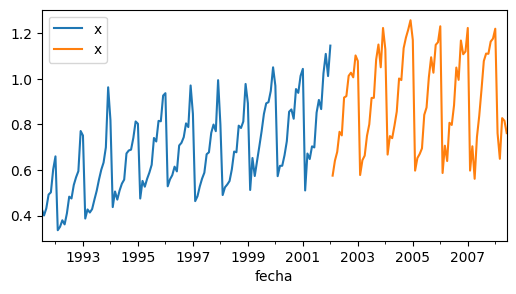

In [6]:
# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

## Extensive Recursive Forecasting